# Introduction to Bioinformatics Workflows and the HPC

Now comes the exciting part! We are going to start working on our class project. This year, we will be analyzing data from a study on Fecal Microbial Transplant (FMT).

Smillie, Christopher S., et al. "Strain tracking reveals the determinants of bacterial engraftment in the human gut following fecal microbiota transplantation." Cell host & microbe 23.2 (2018): 229-240.

This paper follows 19 patients over time after receiving an FMT from 1 of 4 donors. Each of these patients has a recurrent Clostridium difficile infection and traditional antibiotics are not helping them to get better. Let's see if the FMT is succeesful and they move towards a healthy gut microbiome, similar to their donor. 


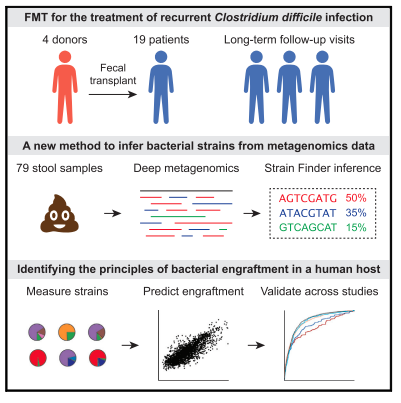

This notebook introduces a general bioinformatics pipeline to process metagenomics data, takes you through the first steps in downloading your data from the SRA to your directory on the HPC. You will receive a small subset of the 110 total metagenomes from this study to process as we work through the steps in our bioinformatics workflow over the next several weeks. We'll be running our bioinformatics tools in containers using apptainer on the HPC. We'll also be running all of our jobs with scripts that run the containers in-parallel. This means that you will kick off one job, but that one job will run each of your metagenomes through a single step in the analysis pipeline simultaneously.This notebook will teach you how to do that.

-----

Sections:
1. Bioinformatic Workflow Introduction
2. Downloading data from the SRA
2. Hands-on introduction to using sbatch to run jobs in parallel on the HPC

-----

A few good resources to help you go deeper:

1. A introduction to the [HPC](https://www.youtube.com/watch?v=xlgL6u1jkVI&ab_channel=UniversityofArizonaUITSResearchTechnologies)
2. An introduction to parallel computing on the [HPC](https://www.youtube.com/watch?v=3Qwhlihf9wc)
3. A link to the github repo from the HPC that has [script examples](https://ua-researchcomputing-hpc.github.io/)

So... [what is a notebook?](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) Simply, it's a document that allows you to use both computational code snippets as well as regular text for explanation/analysis.
We create cells that contain either code (usually Python or R, you can run unix commands as well), or Markdown language for general writing.
After you write your cells, you can select it and click run (or press Ctrl-Enter) and it will run the selected cell.

A key note is that your code will run in the directory where the notebook is saved. So if you have code producing output (exporting a textfile or making a directory with a unix command), it will execute where the notebook file is located -- unless you include unix commands to change the working directory.

The notebook executes in the order you run the cells. This means you can execute the first line of code and then the last line of code if you wanted. Often this breaks your work, so be mindful of the order you're executing code cells. The order is important to the output. 

Finally, as I mentioned you can use unix commands. Here we're working with a python 3 kernel (the computational engine to execute code in our notebook), so in order to run those commands we need to enter a "!" in front of the command, and for the change directory (cd) command it requires a "%". This tells Python that we are running a unix command. 

## 1. Bioinformatic Workflows

Metagenomics analyses require a number of different steps (see the workflow document below). Once you have your sequence reads, you'll run through a quality control stage. After that you will assemble genomes from metagenomes, then bin (cluster the contigs into species-level genome bins), and finally determine the taxonomy. These steps use different file formats, and require specific tools to process the data. These sequential steps that form a single analysis are called pipelines. 

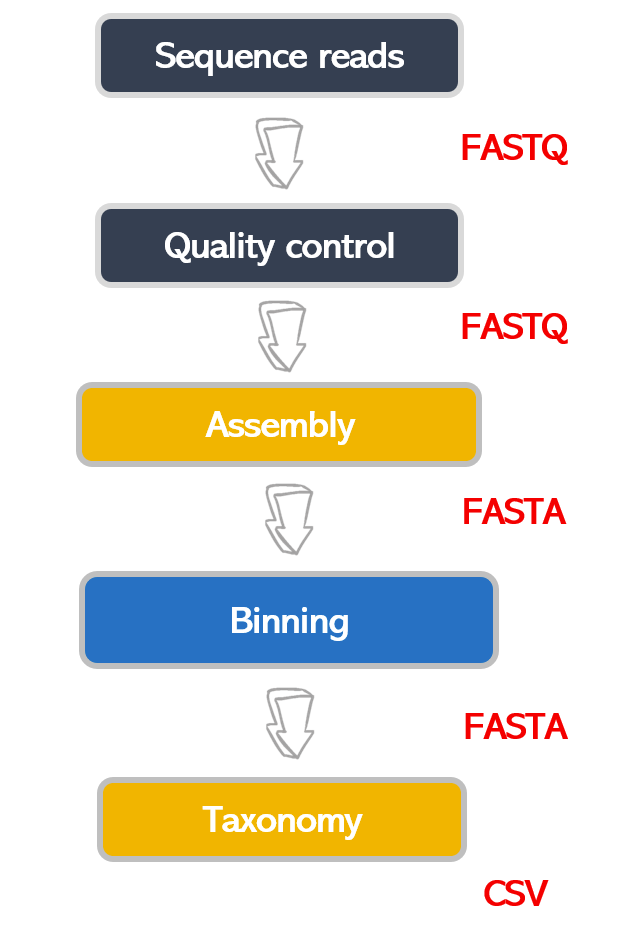

This notebook will be focusing on the very first step in downloading your data from the SRA (Sequence Read Archive)

-----


## 2. Downloading an SRA Accession List from NCBI

The Smillie et al FMT study has 110 metagenomes associated with it. This is way too many for someone to process when they are just starting out. So, instead, we are going to process all of these samples as a class. Each of you should have a file in your 04_intro_hpc directory that begins with an x*

In [ ]:
# Go to your working directory and determine the name of your xfile
netid = "YOUR_NETID"
%cd /xdisk/bhurwitz/bh_class/$netid/assignments/04_intro_hpc
!ls x*

In [ ]:
!cat x*

You should see a list of accessions that look similar to these:

```
ERR2198611
ERR2198616
ERR2198621
ERR2198626
ERR2198631
```

Each one of these accessions refers to one sequencing run for one of the samples in our study. You will have a different list then what is shown above.

To find these accession numbers, I used a similar approach to what you saw from the in-class exercise. First, I looked for the bioproject id that was shown in the paper under Data Availability (at the end of the article). I then searched for this project The National Library of Medicine's National Center for Biotechnology Information [(NCBI)](https://www.ncbi.nlm.nih.gov/) website <br>

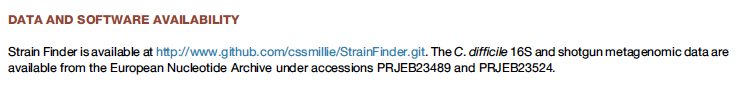

Next I scrolled down to the project data portion and clicked on the number under “SRA Experiments”.

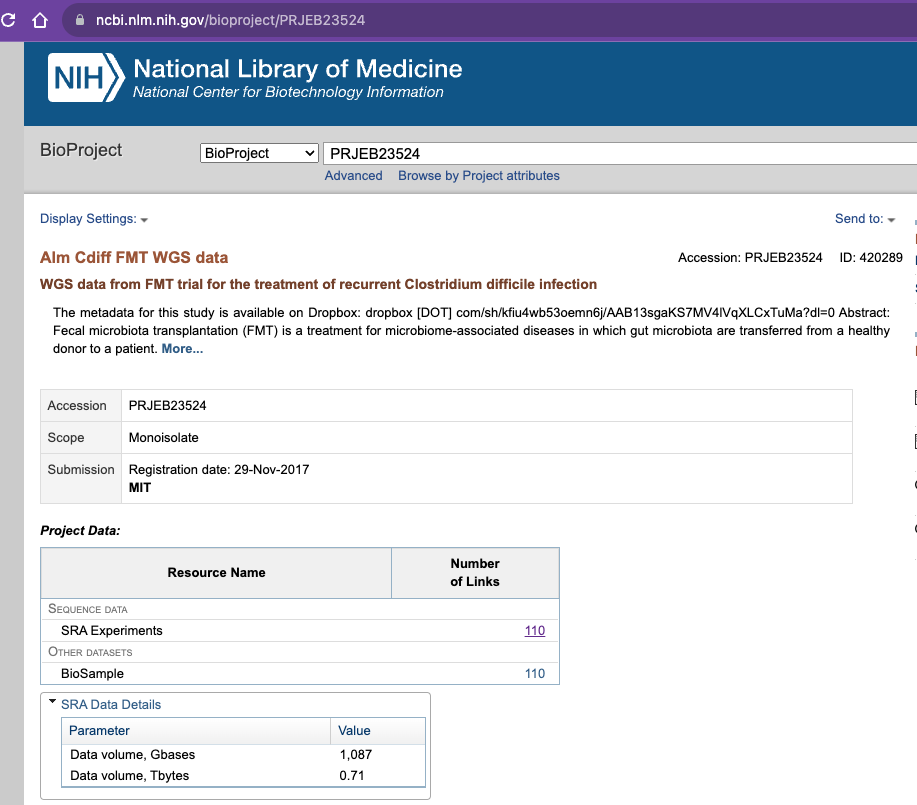

From there, I went to "send to" and selected "run selector" from the drop down menu.

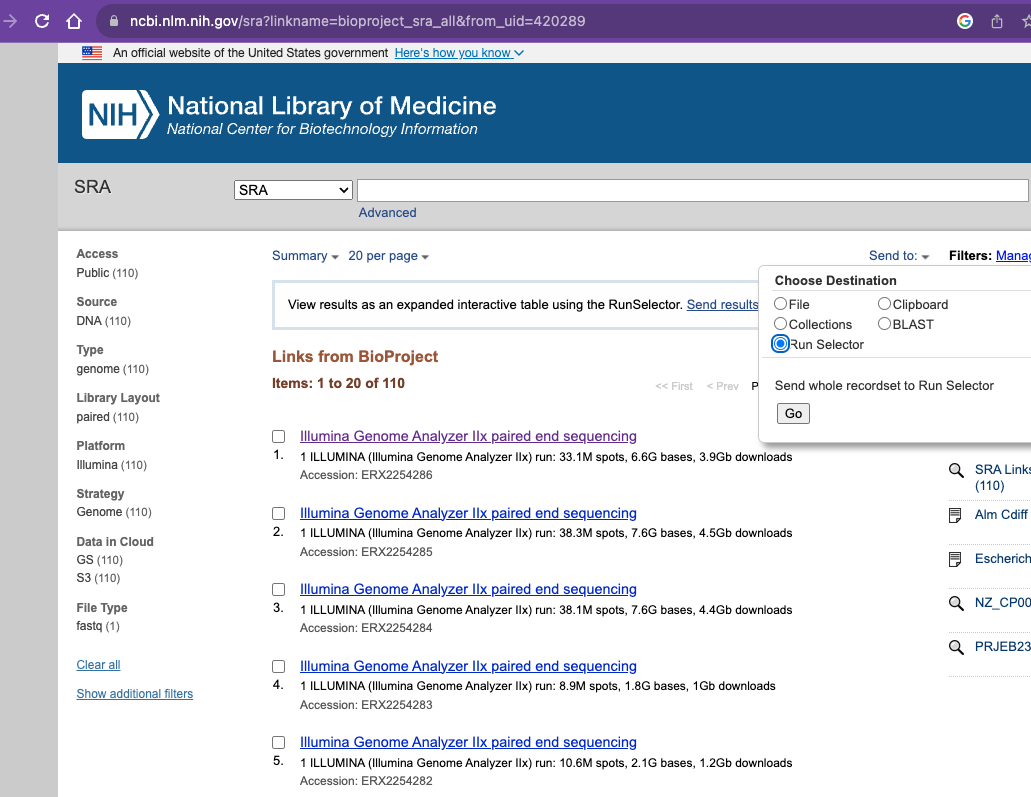

This page shows each sample along with different filters and metadata. We need the SRA Accession List for all the samples, so we’ll select the “Accession List” button for the total samples. This will deliver a text doc called “SRR_Acc_List.txt”. This is the complete list of accessions for the project, of which you should have a small subset in your x* file in /xdisk/bhurwitz/bh_class/$netid/assignments/04_intro_hpc. We will use that file from here on out.

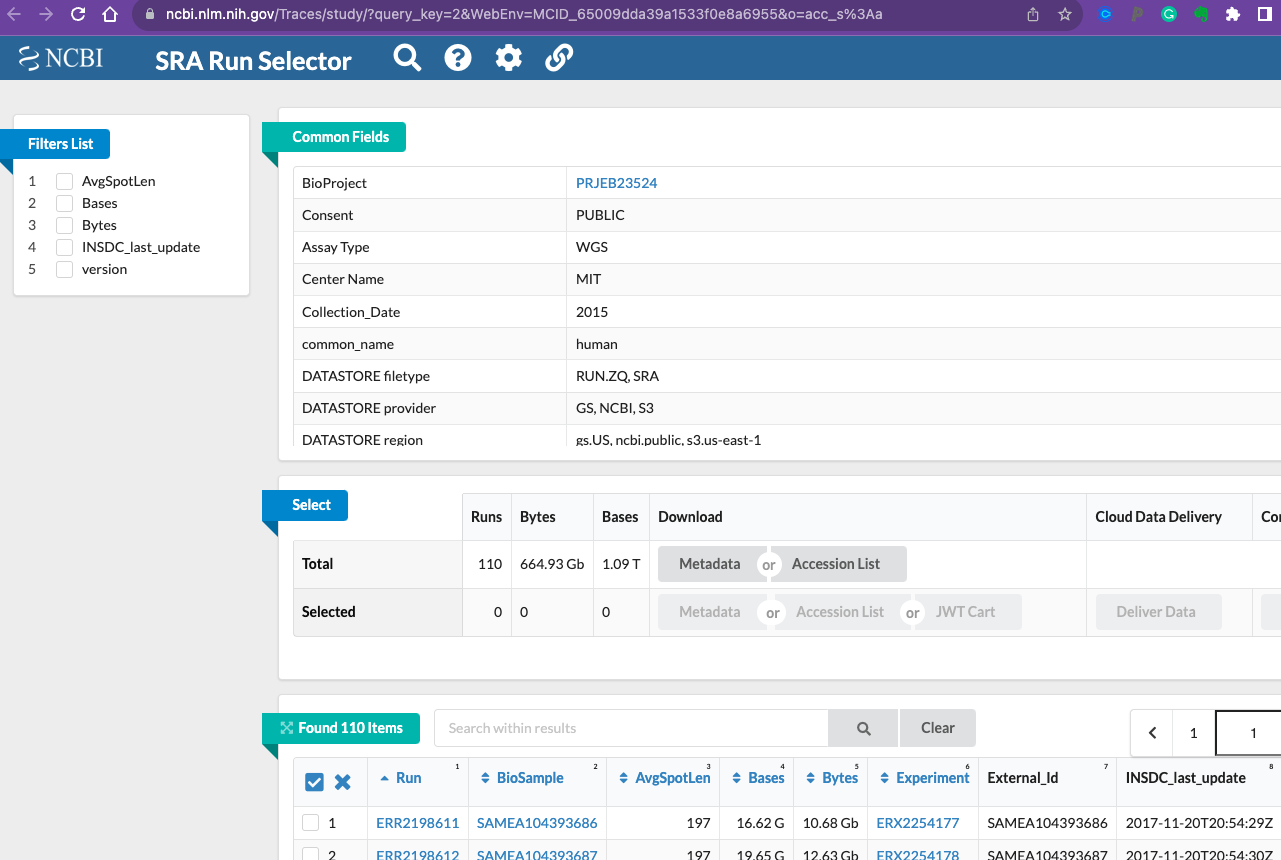

------

## 3. Hands-on Example using Sbatch to run jobs in parallel

The very first step in downloading data from the Sequence Read Archive (SRA)at NCBI is to "pre-fetch" the data using the SRA toolkit. As with all bioinformatics programs in this class, we will be running the tool via a container on the HPC. The UA HPC requires us to use apptainer to create/run our bioinformatics tools. So, you will see that we run the container using the apptainer command. Note that apptainer can only be run from one of the compute nodes, not the login node. As a result, we will need to run apptainer from an sbatch script (that we will write below). 

### 01_Parallel Prefetching

This will be our first script that runs jobs in parallel on the HPC using a job array. Job arrays allow you to leverage SLURM's ability to create multiple jobs from one script. For example, instead of having 5 submission scripts to run the same job step with different arguments, you can have one script to run the 5 job steps at once

Similar to the previous homeworks, we will be using python to "write" the code to our working directory. 

In [ ]:
# You should already be in your working directory, but let's double check
%cd /xdisk/bhurwitz/bh_class/$netid/assignments/04_intro_hpc

You should only see your xfile with your list of accessions.

In [ ]:
!ls

In [ ]:
# Let's create the script by using Python to write it for us.
# Be sure to replace the following with the right information below
# YOUR_NETID
# YOUR_XFILE
my_code = '''#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --nodes=1             
#SBATCH --time=10:00:00   
#SBATCH --partition=standard
#SBATCH --account=bh_class
#SBATCH --array=0-4                          
#SBATCH --output=Job-%a.out
#SBATCH --cpus-per-task=1                    
#SBATCH --mem=4G                             
 
pwd; hostname; date
 
names=($(cat /xdisk/bhurwitz/bh_class/YOUR_NETID/assignments/04_intro_hpc/YOUR_XFILE))
 
echo ${names[${SLURM_ARRAY_TASK_ID}]}

apptainer run /contrib/singularity/shared/bhurwitz/sra-tools-3.0.3.sif prefetch ${names[${SLURM_ARRAY_TASK_ID}]}
'''

with open('prefetch_parallel.sh', mode='w') as file:
    file.write(my_code)

In [ ]:
# make your code executable
!chmod +x prefetch_parallel.sh

### An explanation of the SBATCH script

Let's look at the script above and walk through each component:

    - ntasks are the number of tasks each cluster node will run. In our case each node will run just one task, for one metagenome.
    - nodes are the amount of cluster nodes you're requesting for each job, typically it'll stay 1.
    - time is the max amount a job can run, depending on your data it'll vary but the lower the amount of
      resources you request, the faster your job will get picked up by the scheduler.  
    - parition and account will typically stay the same, it's based on the PI's account you're using.
    - array is the amount of jobs you'll be running the same task on. Since our x* file contains 5 accession ids, our array is (0, 1, 2, 3, 4). Note that we need to start at 0 to match with the SLURM_ARRAY_TASK_ID 
    - output is the title of a text file where the output from the tool is stored for later reference.
    - cpus & mem are resource allocations for different tasks. Different tools have different speeds, but the more resources
      you request the harder it is for your job to get picked up. 
      
Now let's look at the actual script:

    - pwd; hostname; date just provides some output data so we can see basic info about each job
    - names=($(cat SRR_Acc_List.txt)) stores all 5 accession ids in an array within the variable name
    - echo $(names[$SLURM_ARRAY_TASK_ID}]} prints out the current accession number we're working on. 
      It uses the SLURM_ARRAY_TASK_ID to index the names array.
    - apptainer run... this runs a container in the shared tools folder on the node. We're using sra-tools and telling it to use the command prefetch (that is part of sra-tools) and using our array to select one of the 5 IDs based on the SLURM_ARRAY_TASK_ID.

#### Note that our job will run and store results in the folder we are currently in

Double check that your script is in this directory and that we created the script above correctly.

In [ ]:
!pwd
!ls prefetch_parallel.sh

In [ ]:
!cat prefetch_parallel.sh

#### Now let's sbatch our pre-fetch  (in other words, submit a job that runs on a cluster node that runs pre-fetch command from the sra-toolkit)

In [ ]:
!sbatch ./prefetch_parallel.sh

Be sure to replace YOUR_JOBID with the job id from above.

In [ ]:
!squeue --job=YOUR_JOBID

#### Output files from the parallel prefetch

After the job runs we'll see that we have multiple files in our directory. A Job-*.out and a directory that matches each of the ID's from the x* file. 

Note that these files/directories are only present once the job completes.

Great job! This sets us up to actually download the fastq files in the next homework.

In [ ]:
!ls -1

In [ ]:
cp ~/04_intro_hpc.ipynb /xdisk/bhurwitz/bh_class/$netid/assignments/04_intro_hpc

-----